## COMP41680 - Assignment 2: Text Classification

### Introduction

Text Classification is performed to analyze textual data. Similar to any other analysis done on data to study it and find meaningful insight, analyzing text is also important. There are various different tweets, reviews, comments etc which needs to be analyzed to understand user opinions. 

The main aim of this assignment is to scrap the reviews from a web page, store them into a dataset with label Positive where the  star review is less than or equal to 3 or Negative when the star review is greater than 3 and then evaluate the performance of classification on the dataset.  The data of reviews of 5 different categories mentioned to the link below:
http://mlg.ucd.ie/modules/yalp/

As we are asked to use 2 different categories to perform analysis, for this assignment we are using Hotel and Travel & Restaurant data.

##### Importing all the required libraries

In [210]:
import bs4
from urllib.request import urlopen as urlReq
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as soup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Task 1: Scrapping the reviews and rating for categories "Hotel and Review" and "Restaurant" 

In [211]:
# Creating method because we have scrap text from 2 different links for 2 different review category

def scrappingWebText(categoryLink, fileName):
    
    f = open(fileName, "w", encoding="utf-8")      # Writing the reviews to a file
    f.write("ReviewText,ClassLabel\n")      #Creating headers for data in the newly created file      
    
    # Requesting the url link in the function parameter categoryLink and fetching the text on the page
    categoryData = urlReq(categoryLink).read() 
    
    # Processing the html data using the library beautiful soup
    parsedData = soup(categoryData, "html.parser") 
    # print(parsedData)
    
    ####categoryBusinessList = parsedData.find_all("div",{"name":"main"})
    # Extracting the <a> tag avoiding the rest html tags 
    categoryBusinessList = parsedData.find_all("a")
    #print(categoryBusinessList)
    
    # Looping through each business and scrapping only the link required to get the reviews and ratings of different businesses.
    reviewLinks = []
    for i in categoryBusinessList:
        
        # Copying all the links of reviews of businesses into a list named reviewLinks
        reviewLinks.append(i["href"])
    
    #print(reviewLinks)
    
    actualReviewLinks = []
    for i in reviewLinks:
        
        # appending the link http://mlg.ucd.ie/modules/yalp/ to all the reviews in reviewLinks list to get the actual data
        actualReviewLinks.append("http://mlg.ucd.ie/modules/yalp/" + i)
    
    #print(actualReviewLinks)
    
    # Processing actual data and writing the reviews and ratings to file
    for link in actualReviewLinks:
        textData = urlReq(link).read()    # Requesting the Review link and reading the review text and ratings
        
        # Parsing the html data
        parsedData = soup(textData, "html.parser")
        
        # Fetching all the <div> tags with class review
        reviewAndRatings = parsedData.find_all("div",{"class":"review"})
        #print(reviewAndRatings)
    
        # Iterating through each tag that consists of comment text and rating star data
        for i in reviewAndRatings:
            rating = i.img["alt"]    # To get star rating 
            
            # Logic to check the rating and set it to appropriate class labels
            if(rating == '5-star' or rating == '4-star'):
                finalRating = 'Positive'
            else:
                finalRating = 'Negative'
            
            # Getting reviews text 
            review = i.find_all("p",{"class":"text"})

            finalReview = review[0].text.strip()     # Stripping the text data to remove extra spaces
            finalReview = finalReview.replace(",", " ")     # Removing ',' and replacing with space to store the entire content
                                                            # as one field vale in the CSV file.
            
            # Writing the review and rating data to file
            row = finalReview +","+ finalRating +"\n"
            f.write(row)
 
            

In [212]:
# calling the function to scrap the reviews and ratings for hotel and travel companies
scrappingWebText("http://mlg.ucd.ie/modules/yalp/hotels_travel_list.html", "HotelsAndTravel.csv")

# calling the function to scrap the reviews and ratings for different Restaurants
scrappingWebText("http://mlg.ucd.ie/modules/yalp/restaurants_list.html", "Restaurant.csv")

### Task 2: Performing pre-processing on the data collected for categories
### Task 3: Evaluating how well classification model transfer between categories

In [213]:
# Reading data for CSV files both the categories - HotelAndTravel and Restaurant
data_hotelandtravel = pd.read_csv("HotelsAndTravel.csv")
data_restaurant=pd.read_csv("Restaurant.csv")

# Getting the total number of rows in each dataframe
length_handt = len(data_hotelandtravel)
len_res = len(data_restaurant)

In [214]:
# Combining the data of both the dataframes together into a single dataframe
combine = data_hotelandtravel.append(data_restaurant, ignore_index=True)
combine

,ReviewText,ClassLabel
0,I have used this service before and was satisf...,Negative
1,First time I tried using them the driver was n...,Negative
2,Driver picked me up on time at 6AM and even kn...,Positive
3,First time using this taxi and limo company as...,Positive
4,Great experience. Driver was early and was ver...,Positive
5,Ive used Aeroport a few times now and i highly...,Positive
6,Got of the plane walked out of the airport the...,Positive
7,Can't fault the service. Arrives on time every...,Positive
8,Limousine was on time. Driver was very helpful...,Positive
9,Made my reservation online. Was picked up on t...,Positive


In [215]:
# Cleaning data by removing words that doesn't consists of alphabets and removing words with length less than or equal to 3. 
combine['Clean text'] = combine['ReviewText'].str.replace("[^a-zA-Z]", " ")
combine['Clean text'] = combine['Clean text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
#tokens = combine['Clean text'].apply(lambda x: x.split())

# grenerating tokens
tokens =combine['Clean text'].apply(lambda x: nltk.word_tokenize(x.lower()))


For using the pos_tag command of nltk package, it is important to download the package 'averaged_perceptron_tagger' to allow the command tag_pos generate different tags for a word

**Execute this command if required: nltk.download('averaged_perceptron_tagger')

We came across this error when we tested this python code on a different system which didn't had the package installed. 

In [216]:
# Each word in a sentence has its own identification in the context. It may represent a noun, verb, preposition or 
# other determination. Thus taggers are used to assign different tags for each words.

tokens =tokens.apply(lambda x: nltk.pos_tag(x))

In [217]:
# Will generate output with each word with its tag.

tokens

0       [(have, VB), (used, VBN), (this, DT), (service...
1       [(first, JJ), (time, NN), (tried, VBN), (using...
2       [(driver, NN), (picked, VBD), (time, NN), (eve...
3       [(first, JJ), (time, NN), (using, VBG), (this,...
4       [(great, JJ), (experience, NN), (driver, RB), ...
5       [(used, VBN), (aeroport, NN), (times, NNS), (h...
6       [(plane, NN), (walked, VBD), (airport, NN), (w...
7       [(fault, NN), (service, NN), (arrives, NNS), (...
8       [(limousine, JJ), (time, NN), (driver, VB), (v...
9       [(made, VBN), (reservation, NN), (online, NN),...
10      [(great, JJ), (cars, NNS), (drivers, NNS), (ev...
11      [(used, VBN), (these, DT), (guys, NNS), (times...
12      [(ordered, VBN), (pick, NN), (only, RB), (came...
13      [(great, JJ), (experience, NN), (from, IN), (p...
14      [(reserved, VBN), (minivan, NN), (with, IN), (...
15      [(very, RB), (good, JJ), (experience, NN), (dr...
16      [(brutal, JJ), (driver, NN), (very, RB), (unha...
17      [(took

For using the Lemmatize command of nltk package, it is important to download the package 'wordnet'.

**Execute this command if required: nltk.download('wordnet')

We came across this error when we tested this python code on a different system which didn't had the package installed. 

In [218]:
# Lemmatizing words to claen the data. Lemmatizing breaks the words and removes verb tenses.
# Using nltk WordNetLemmatizer
wnl = nltk.WordNetLemmatizer()

# Function to convert the tags assigned to each word to char 'v' or 'n' so that Lemmatize method can understand and perform the
# operation accordingly.
def convert_tags(tag):
    if tag=='vbd' or tag=='vbg' or tag=='vbz':
        return 'v'
    else:
        return 'n'
    
# Iterating through each word and lemmatizing them based on the tags
count=0
for l in tokens:
    temp=[]
    for w in l:
        new_tag=convert_tags(w[1].lower())
        temp.append(wnl.lemmatize(w[0], new_tag))
    tokens[count]=' '.join(temp)
    count+=1
    
# Printing the tokens
tokens

0       have used this service before satisfy until ju...
1       first time tried use them driver nowhere found...
2       driver pick time even knock door instead ring ...
3       first time use this taxi limo company have use...
4       great experience driver early very friendly th...
5       used aeroport time highly recommend always tim...
6       plane walk airport wait walk brought could lug...
7       fault service arrives time every time have use...
8       limousine time driver very helpful courteous v...
9       made reservation online pick time driver court...
10      great car driver even minivan extra whole fami...
11      used these guy time they make your trip airpor...
12      ordered pick only come call inquired about ope...
13      great experience from pearson terminal front d...
14      reserved minivan with carseat pick billy bisho...
15      very good experience driver arrive min early l...
16      brutal driver very unhappy person seem like ne...
17      take m

In [219]:
# Copying the processed review data into a column in the already existing dataframe named combine.  
combine['Clean text'] = tokens

# Converting the ClassLabels Positive and Negative to 0 or 1 
combine['ClassLabel'] = combine['ClassLabel'].apply(lambda x: 1 if x=='Positive' else 0 ) 

#Printing combine to check whether the Column "Clean text" is added and the values for "ClassLabel" column is modified
combine

,ReviewText,ClassLabel,Clean text
0,I have used this service before and was satisf...,0,have used this service before satisfy until ju...
1,First time I tried using them the driver was n...,0,first time tried use them driver nowhere found...
2,Driver picked me up on time at 6AM and even kn...,1,driver pick time even knock door instead ring ...
3,First time using this taxi and limo company as...,1,first time use this taxi limo company have use...
4,Great experience. Driver was early and was ver...,1,great experience driver early very friendly th...
5,Ive used Aeroport a few times now and i highly...,1,used aeroport time highly recommend always tim...
6,Got of the plane walked out of the airport the...,1,plane walk airport wait walk brought could lug...
7,Can't fault the service. Arrives on time every...,1,fault service arrives time every time have use...
8,Limousine was on time. Driver was very helpful...,1,limousine time driver very helpful courteous v...
9,Made my reservation online. Was picked up on t...,1,made reservation online pick time driver court...


In [221]:
# When working on text data it is important to remove unwanted words by performing tokenizing and extract the features 
# that enable to make predictions. Thus to convert this textual data into vector of numeric value we use Bag of words Model.
# The Model also help remove stop words.
# Here, we are using of the scheme of Bag of words model named CountVectorizer to focus on the occurrence of each words.

bag_of_words_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bag_of_words = bag_of_words_vectorizer.fit_transform(combine['Clean text'])

In [222]:
# As both the category data was combined together into one frame, the steps below are dividing the review data stored in 
# bags_of_words and Class labels back to its respective dataframe based on the length of the data (i.e no of rows) stored 
# into a variable above. 
category_A_data = bag_of_words[length_handt:,:]
category_B_data = bag_of_words[:length_handt,:]

classlabel=combine['ClassLabel']
category_A_label=classlabel[length_handt:]
category_B_label=classlabel[:length_handt]

In [223]:
# splitting data into training and validation set
xtrain_A, xtest_A, ytrain_A, ytest_A = train_test_split(category_A_data, category_A_label, random_state=42, test_size=0.3)

xtrain_B, xtest_B, ytrain_B, ytest_B = train_test_split(category_B_data, category_B_label, random_state=42, test_size=0.3)

### Logistic Regression: 

In [224]:
logreg = LogisticRegression()

#training the model based on category A data i.e. Hotel and Travel
logreg.fit(xtrain_A, ytrain_A) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [225]:
# Testing the trained model on Category A data test data.
test_pred = logreg.predict_proba(xtest_A)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

# Calculating the accuracy
LR_trainAtestA = accuracy_score(ytest_A, test_pred_int)
print("Accuracy train(A), test(A): ",trainAtestA)

Accuracy train(A), test(A):  0.7893518518518519


In [226]:
# Testing the trained model on Category B data test data.
test_pred = logreg.predict_proba(xtest_B)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

# Calculating the accuracy
LR_trainAtestB = accuracy_score(ytest_B, test_pred_int)
print("Accuracy train(A), test(B): ",LR_trainAtestB)

Accuracy train(A), test(B):  0.7808857808857809


In [227]:
#training the model on Category B data i.e. Restaurant Data
logreg.fit(xtrain_B, ytrain_B) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [228]:
# Testing the trained model on Category B data test data.
test_pred = logreg.predict_proba(xtest_B)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

# Calculating the accuracy
LR_trainBtestB = accuracy_score(ytest_B, test_pred_int)
print("Accuracy train(B), test(B): ", LR_trainBtestB)

Accuracy train(B), test(B):  0.8624708624708625


In [229]:
# Testing the trained model on Category A test data.
test_pred = logreg.predict_proba(xtest_A)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

# Calculating the accuracy
LR_trainBtestA = accuracy_score(ytest_A, test_pred_int)
print("Accuracy train(B), test(A): ", LR_trainBtestA)

Accuracy train(B), test(A):  0.7893518518518519


In [230]:
# Creating dataframe for model classified using Logistic Regression Classifier
Data = {"headers": ["trainAtestA", "trainAtestB", "trainBtestB", "trainBtestA"],
        "data": [LR_trainAtestA, LR_trainAtestB, LR_trainBtestB, LR_trainBtestA]
       }

df = pd.DataFrame(Data)
#df.set_index("headers")
df

,headers,data
0,trainAtestA,0.798611
1,trainAtestB,0.780886
2,trainBtestB,0.862471
3,trainBtestA,0.789352


Barchart for visualizing model accuracy when generated prediction using testdata for each category.

[Text(0, 0, 'trainAtestA'),
 Text(0, 0, 'trainAtestB'),
 Text(0, 0, 'trainBtestB'),
 Text(0, 0, 'trainBtestA')]

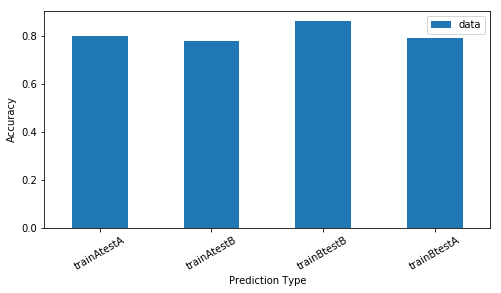

In [231]:
p = df.plot.bar(figsize=(8, 4))
p.set_xlabel("Prediction Type")
p.set_ylabel("Accuracy")
p.set_xticklabels(df["headers"], rotation=30)

### Support Vector Machine

In [232]:
clf=svm.SVC(kernel='linear')

#training the model on Category A data i.e. Hotel and Travel Data
clf.fit(xtrain_A,ytrain_A)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [233]:
# Testing the trained model on Category A test data.
pred=clf.predict(xtest_A)

# Calculating Accuracy
SVM_trainAtestA = accuracy_score(ytest_A, pred)
print("Accuracy train(A), test(A): ", SVM_trainAtestA)

Accuracy train(A), test(A):  0.8101851851851852


In [234]:
# Testing the trained model on Category B test data.
pred=clf.predict(xtest_B)

#Calculating Accuracy
SVM_trainAtestB = accuracy_score(ytest_B, pred)
print("Accuracy train(A), test(B): ", SVM_trainAtestB)

Accuracy train(A), test(B):  0.745920745920746


In [235]:
#training the model on Category B data i.e. Restaurants Data
clf.fit(xtrain_B,ytrain_B)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [236]:
# Testing the trained model on Category B test data.
pred=clf.predict(xtest_B)

#Claculating Accuracy
SVM_trainBtestB = accuracy_score(ytest_B, pred)
print("Accuracy train(B), test(B): ", SVM_trainBtestB)

Accuracy train(B), test(B):  0.8344988344988346


In [237]:
# Testing the trained model on Category A test data.
pred=clf.predict(xtest_A)

#Claculating Accuracy
SVM_trainBtestA = accuracy_score(ytest_A, pred)
print("Accuracy train(B), test(A): ", SVM_trainBtestA)

Accuracy train(B), test(A):  0.7546296296296297


In [238]:
# Creating dataframe for model classified using Support Vector Machine Classifier
Data = {"headers": ["trainAtestA", "trainAtestB", "trainBtestB", "trainBtestA"],
        "data": [SVM_trainAtestA, SVM_trainAtestB, SVM_trainBtestB, SVM_trainBtestA]
       }

df = pd.DataFrame(Data)
df

,headers,data
0,trainAtestA,0.810185
1,trainAtestB,0.745921
2,trainBtestB,0.834499
3,trainBtestA,0.754630


Bar chart for visualizing the accuracy of predictions done of different test data using the trained model

[Text(0, 0, 'trainAtestA'),
 Text(0, 0, 'trainAtestB'),
 Text(0, 0, 'trainBtestB'),
 Text(0, 0, 'trainBtestA')]

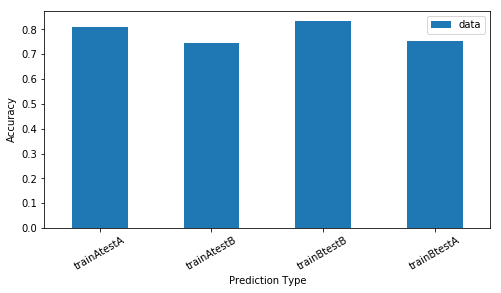

In [239]:
p = df.plot.bar(figsize=(8, 4))
p.set_xlabel("Prediction Type")
p.set_ylabel("Accuracy")
p.set_xticklabels(df["headers"], rotation=30)

### Random Forest

In [240]:
model=RandomForestClassifier(n_estimators=500,max_depth=20,random_state=50)

##training the model on Category A data i.e. Hotel and Travel Data
model.fit(xtrain_A,ytrain_A)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [241]:
# Testing the trained model on Category A test data.
pred=model.predict(xtest_A)

# Caluclating Accuracy
RF_trainAtestA = accuracy_score(ytest_A, pred)
print("Accuracy train(A), test(A): ",RF_trainAtestA)

Accuracy train(A), test(A):  0.7824074074074074


In [242]:
# Testing the trained model on Category B test data.
pred=model.predict(xtest_B)

# Calculating Accuracy
RF_trainAtestB = accuracy_score(ytest_B, pred)
print("Accuracy train(A), test(B): ",RF_trainAtestB)

Accuracy train(A), test(B):  0.7645687645687645


In [243]:
# training the model on Category B data i.e. Restaurants Data
model.fit(xtrain_B,ytrain_B)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [244]:
# Testing the trained model on Category B test data. 
pred=model.predict(xtest_B)

# Calculating Accuracy
RF_trainBtestB = accuracy_score(ytest_B, pred)
print("Accuracy train(B), test(B): ",RF_trainBtestB)

Accuracy train(B), test(B):  0.8344988344988346


In [245]:
# Testing the trained model on Category A test data.
pred=model.predict(xtest_A)

# Calculating Accuracy
RF_trainBtestA = accuracy_score(ytest_A, pred)
print("Accuracy train(B), test(A): ",RF_trainBtestA)

Accuracy train(B), test(A):  0.7685185185185185


In [246]:
# Creating dataframe for model classified using Random Forest Classifier
Data = {"headers": ["trainAtestA", "trainAtestB", "trainBtestB", "trainBtestA"],
        "data": [RF_trainAtestA, RF_trainAtestB, RF_trainBtestB, RF_trainBtestA]
       }

df = pd.DataFrame(Data)
df

,headers,data
0,trainAtestA,0.782407
1,trainAtestB,0.764569
2,trainBtestB,0.834499
3,trainBtestA,0.768519


Bar chart for visualizing the accuracy of predictions done of different test data using the trained model

[Text(0, 0, 'trainAtestA'),
 Text(0, 0, 'trainAtestB'),
 Text(0, 0, 'trainBtestB'),
 Text(0, 0, 'trainBtestA')]

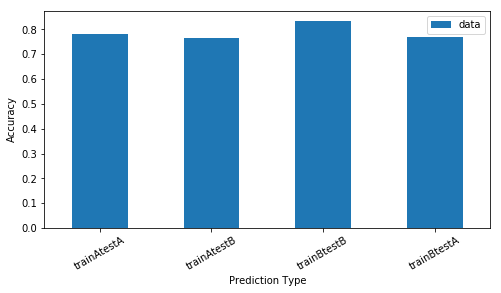

In [247]:
p = df.plot.bar(figsize=(8, 4))
p.set_xlabel("Prediction Type")
p.set_ylabel("Accuracy")
p.set_xticklabels(df["headers"], rotation=30)

### kNN Classifier

In [248]:
model = KNeighborsClassifier(n_neighbors=6)

# training the model on Category B data i.e. Hotel and Travel Data
model.fit(xtrain_A, ytrain_A)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [249]:
# Testing the trained model on Category A test data.
pred= model.predict(xtest_A) 

# Calculating Accuracy
kNN_trainAtestA = accuracy_score(ytest_A, pred)
print("Accuracy train(A), test(A): ",kNN_trainAtestA)

Accuracy train(A), test(A):  0.7268518518518519


In [250]:
# Testing the trained model on Category B test data.
pred= model.predict(xtest_B)

# Calculating Accuracy
kNN_trainAtestB = accuracy_score(ytest_B, pred)
print("Accuracy train(A), test(B): ",kNN_trainAtestB)

Accuracy train(A), test(B):  0.703962703962704


In [251]:
# training the model on Category B data i.e. Restaurants Data
model.fit(xtrain_B, ytrain_B)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [252]:
# Testing the trained model on Category B test data.
pred= model.predict(xtest_B)

# Calculating Accuracy
kNN_trainBtestB = accuracy_score(ytest_B, pred)
print("Accuracy train(B), test(B): ", kNN_trainBtestB)

Accuracy train(B), test(B):  0.6946386946386947


In [253]:
# Testing the trained model on Category A test data.
pred= model.predict(xtest_A)

# Calculating Accuracy
kNN_trainBtestA = accuracy_score(ytest_A, pred)
print("Accuracy train(B), test(A): ", kNN_trainBtestA)

Accuracy train(B), test(A):  0.5578703703703703


In [254]:
# Creating dataframe for model classified using k Nearest Neighbour Classifier
Data = {"headers": ["trainAtestA", "trainAtestB", "trainBtestB", "trainBtestA"],
        "data": [kNN_trainAtestA, kNN_trainAtestB, kNN_trainBtestB, kNN_trainBtestA]
       }

df = pd.DataFrame(Data)
df

,headers,data
0,trainAtestA,0.726852
1,trainAtestB,0.703963
2,trainBtestB,0.694639
3,trainBtestA,0.557870


Bar chart for visualizing the accuracy of predictions done of different test data using the trained model

[Text(0, 0, 'trainAtestA'),
 Text(0, 0, 'trainAtestB'),
 Text(0, 0, 'trainBtestB'),
 Text(0, 0, 'trainBtestA')]

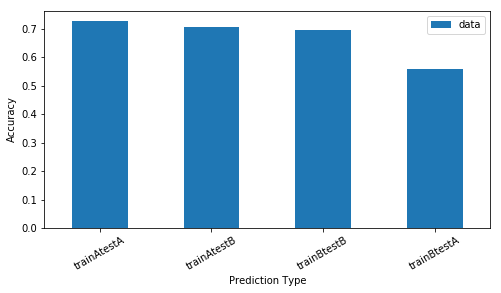

In [255]:
p = df.plot.bar(figsize=(8, 4))
p.set_xlabel("Prediction Type")
p.set_ylabel("Accuracy")
p.set_xticklabels(df["headers"], rotation=30)

### Naive bayes

In [256]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

# training the model on Category B data i.e. Hotel and Travel Data
model.fit(xtrain_A.toarray(), ytrain_A)

GaussianNB(priors=None, var_smoothing=1e-09)

In [257]:
# Testing the trained model on Category A test data.
pred= model.predict(xtest_A.toarray())

# Calculating Accuracy
NB_trainAtestA = accuracy_score(ytest_A, pred)
print("Accuracy train(A), test(A): ", NB_trainAtestA)

Accuracy train(A), test(A):  0.7106481481481481


In [258]:
# Testing the trained model on Category B test data.
pred= model.predict(xtest_B.toarray())

# Calculating Accuracy
NB_trainAtestB = accuracy_score(ytest_B, pred)
print("Accuracy train(A), test(B):", NB_trainAtestB)

Accuracy train(A), test(B): 0.5594405594405595


In [259]:
# training the model on Category B data i.e. Restaurants Data
model.fit(xtrain_B.toarray(), ytrain_B)

GaussianNB(priors=None, var_smoothing=1e-09)

In [260]:
# Testing the trained model on Category B test data.
pred= model.predict(xtest_B.toarray())

#Calculating Accuracy
NB_trainBtestB = accuracy_score(ytest_B, pred)
print("Accuracy train(B), test(B): ", NB_trainBtestB)

Accuracy train(B), test(B):  0.7902097902097902


In [261]:
# Testing the trained model on Category A test data.
pred= model.predict(xtest_A.toarray())

# Calculating Accuracy
NB_trainBtestA = accuracy_score(ytest_A, pred)
print("Accuracy train(B), test(A): ", NB_trainBtestA)

Accuracy train(B), test(A):  0.6574074074074074


In [262]:
# Creating dataframe for model classified using Naive Bayes Classifier
Data = {"headers": ["trainAtestA", "trainAtestB", "trainBtestB", "trainBtestA"],
        "data": [NB_trainAtestA, NB_trainAtestB, NB_trainBtestB, NB_trainBtestA]
       }

df = pd.DataFrame(Data)
df

,headers,data
0,trainAtestA,0.710648
1,trainAtestB,0.559441
2,trainBtestB,0.790210
3,trainBtestA,0.657407


Bar chart for visualizing the accuracy of predictions done of different test data using the trained model

[Text(0, 0, 'trainAtestA'),
 Text(0, 0, 'trainAtestB'),
 Text(0, 0, 'trainBtestB'),
 Text(0, 0, 'trainBtestA')]

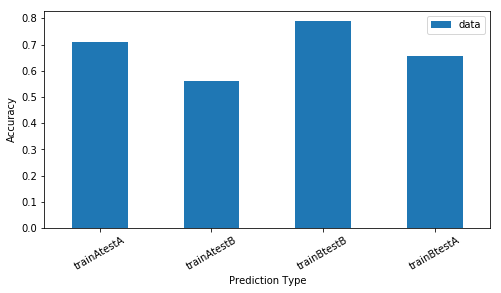

In [263]:
p = df.plot.bar(figsize=(8, 4))
p.set_xlabel("Prediction Type")
p.set_ylabel("Accuracy")
p.set_xticklabels(df["headers"], rotation=30)

### Conclusion

We have implemented the Ensemble technique in order to choose the best classifier for our model.
We have implemented the following classifiers.
1. Logistic Regression
2. Support Vector Machine
3. Random Forest
4. k-nn classifier
5. Naive Bayes Classifier <br>

We are going to compare the performance of each classifier model on the same dataset and on the different dataset. 
We will select the best performing classifiers which have the best accuarcy when subjected to the test data of both the datasets. 

##### Observations for each classifier performance when trained and tested on same category data

For Hotel and Travel dataset, the model trained using Support Vector Machine Classifier performs well as it gives the highest accuracy (81%) when compared to accuracy of other classifiers. Similary, for Restaurant dataset, Logistic Regression classifier give the best performance result (86%). 
If we have to choose one classifier which performs the best when trained and tested on the same dataset, we can choose Support Vector Machine classifier as it performs the best with accuracy=81% for Hotel and Travel dataset and accuracy=83% for Restaurant dataset.

In [264]:
Data = {"Classifiers": ["Logistic Regression", "Support Vector Machine", "Random Forest", "k Nearest Neighbour", "Naive Bayes"],
        "trainAtestA": [LR_trainAtestA, SVM_trainAtestA, RF_trainAtestA, kNN_trainAtestA, NB_trainAtestA],
        "trainAtestB": [LR_trainAtestB, SVM_trainAtestB, RF_trainAtestB, kNN_trainAtestB, NB_trainAtestB],
        "trainBtestB": [LR_trainBtestB, SVM_trainBtestB, RF_trainBtestB, kNN_trainBtestB, NB_trainBtestB],
        "trainBtestA": [LR_trainBtestA, SVM_trainBtestA, RF_trainBtestA, kNN_trainBtestA, NB_trainBtestA]
       }

df = pd.DataFrame(Data)

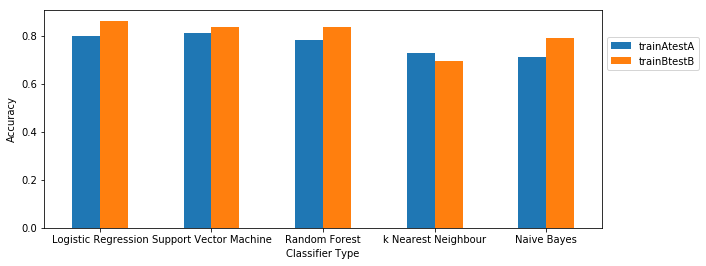

In [265]:
df1 = df[["Classifiers", "trainAtestA", "trainBtestB"]]

p = df1.plot.bar(figsize=(10, 4))
p.set_xlabel("Classifier Type")
p.set_ylabel("Accuracy")
p.set_xticklabels(df["Classifiers"], rotation=0)
p.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))

##### Observations for each classifier performance when trained and tested on different category data

Considering that we have chosen Support Vector Machine Classifier as the best classifier for Hotel And Travel dataset we will now compare the performance of the Restaurant dataset on this model, we get the accuracy of 74%. 

Similarly for Restaurant dataset we have chosen Logistic Regression Classifier to be the best and will compare the performance of the Hotel and Travel dataset on this model and we get accuracy of 78%. 

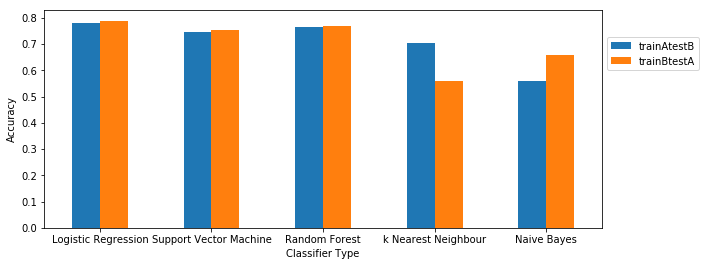

In [266]:
df2 = df[["Classifiers", "trainAtestB", "trainBtestA"]]

p = df2.plot.bar(figsize=(10, 4))
p.set_xlabel("Classifier Type")
p.set_ylabel("Accuracy")
p.set_xticklabels(df["Classifiers"], rotation=0)
p.legend(loc='center left', bbox_to_anchor=(1.0, 0.8))

Considering that the trained model should perform well for any unknown new data, we can choose the classifier that performs well when tested on different dataset. We can conclude that Logistic Regression model performs the best and Random Forest model
is also recommended.

In [267]:
df

,Classifiers,trainAtestA,trainAtestB,trainBtestB,trainBtestA
0,Logistic Regression,0.798611,0.780886,0.862471,0.789352
1,Support Vector Machine,0.810185,0.745921,0.834499,0.754630
2,Random Forest,0.782407,0.764569,0.834499,0.768519
3,k Nearest Neighbour,0.726852,0.703963,0.694639,0.557870
4,Naive Bayes,0.710648,0.559441,0.790210,0.657407
